In [ ]:
import xml.dom
from xml.dom import minidom
from xml.dom import pulldom 

In [ ]:
doc_smiley = minidom.parse("sample_svg.xml")
doc_smiley.attributes
doc_smiley.childNodes

In [ ]:
docs = minidom.parseString("""\
                           <svg viewBox="-105 -100 210 270">
                           </svg>""")
docs.hasChildNodes()

In [ ]:
doc_smiley.version, doc_smiley.encoding, doc_smiley.standalone

In [ ]:
dtd = doc_smiley.doctype
dtd.entities['custom_entity'].childNodes

In [ ]:
doc_smiley.documentElement

In [ ]:
# XML doesn't carry meaning for the attributes or the elements, one needs to use .setAttribute() 

from xml.dom.minidom import parse, Node

def set_id_attribute(parent, attribute_name="id"):
    """Walk through all the elements, and set the attr
    manually"""
    if parent.nodeType == Node.ELEMENT_NODE:
        if parent.hasAttribute(attribute_name):
            parent.setIdAttribute(attribute_name)
    for child in parent.childNodes:
        set_id_attribute(child, attribute_name)

document = parse("sample_svg.xml")
set_id_attribute(document)

In [ ]:
document.getElementById("skin")

In [ ]:
document.getElementsByTagName("ellipse")

In [ ]:
root = document.documentElement

In [ ]:
root.getElementsByTagName("ellipse")

In [ ]:
document.getElementsByTagNameNS(
    "http://www.inkscape.org/namespaces/inkscape",
    "custom"
)
# Search all the namespace provide the *
document.getElementsByTagNameNS("*", "custom")

In [ ]:
element = document.getElementById('smiley')

In [ ]:
element.parentNode, element.firstChild, element.lastChild, element.nextSibling, element.previousSibling

In [ ]:
def remove_whitespace(node):
    if node.nodeType == Node.TEXT_NODE:
        if node.nodeValue.strip() == "":
            node.nodeValue = ""
    for child in node.childNodes:
        remove_whitespace(child)

document = parse("sample_svg.xml")
set_id_attribute(document)
remove_whitespace(document)
document.normalize()

In [ ]:
element = document.getElementById("smiley")
element.childNodes

In [ ]:
# Xml.Sax interface, the ContentHandler instance to be used

from xml.sax import parse
from xml.sax.handler import ContentHandler
from xml.sax.xmlreader import AttributesImpl

def clean(element):
    element["value"] = element["value"].strip()
    for key in ("attributes", "children", "value"):
        if not element[key]:
            del element[key]

class SVGHandler(ContentHandler):
    def __init__(self):
        super().__init__()
        self.element_stack = []

    @property
    def current_element(self):
        return self.element_stack[-1]

    # pass  # this class has to overload contentHandler
    def startElement(self, name: str, attrs: AttributesImpl) -> None:
        print(f"Begin: <{name}>, {attrs.keys()}")
    
    def endElement(self, name: str) -> None:
        print(f"End: </{name}>")
        clean(self.current_element)
        if len(self.element_stack) > 1:
            child = self.element_stack.pop()
            self.current_element["children"].append(child)
     
    def characters(self, content: str) -> None:
        self.current_element["value"] += content
        if content.strip() != "":
            print("Content:", repr(content))
    
    def startElement(self, name, attrs):
        self.element_stack.append({
            "name": name,
            "attributes": dict(attrs),
            "children": [],
            "value": ""
        })

In [ ]:
handler = SVGHandler()
root = parse("sample_svg.xml", handler)

In [ ]:
import json

print(json.dumps(root, indent=4))

In [ ]:
# sax, pull and minidom modules work together. Pulldom acts as wrapper to sax and mini

from xml.dom.pulldom import parse
event_stream = parse("sample_svg.xml")
for event, node in event_stream:
    print(event, node)

All the above modules are antiquated modules, the pythonic alternate is xml.etree.ElementTree 

In [ ]:
import xml.etree.ElementTree as ET

In [ ]:
etparse = ET.parse("sample_svg.xml")

In [ ]:
parseStr = ET.fromstring("""\
                         <svg viewBox="-105 -100 210 270">
                         </svg>""")

In [ ]:
#iterparse uses blocking calls, which is the downside
for event, element in ET.iterparse("sample_svg.xml", ["comment"]):
    print(event, element.tag)
    print(element.text.strip())

Here’s a list of all the available event types:

start: Start of an element

end: End of an element

comment: Comment element

pi: Processing instruction, as in XSL

start-ns: Start of a namespace

end-ns: End of a namespace

In [ ]:
import xml.etree.ElementTree as ET

async def receive_data(url):
    """Download chunks of bytes from the URL asynchronously."""
    yield b"<svg "
    yield b"viewBox=\"-105 -100 210 270\""
    yield b"></svg>"

async def parse(url, events=None):
    parser = ET.XMLPullParser(events)
    async for chunk in receive_data(url):
        parser.feed(chunk)
        for event, element in parser.read_events():
            yield event, element

In [ ]:
root = etparse.getroot()

In [ ]:
for descendant in root.iter():
    print(descendant.tag)

# It’s also possible to narrow down the descendants by filtering only specific tag names using 

In [ ]:
elem = root[0]
elem.tag

In [ ]:
elem.text

In [ ]:
elem.attrib

In [ ]:
tag_name = "{http://www.w3.org/2000/svg}ellipse"
for descendant in root.iter(tag_name):
    print(descendant)

In [ ]:
# dealing with namespace is easier with iterfind

namespaces = {
    "": "http://www.w3.org/2000/svg",
    "custom": "http://www.w3.org/2000/svg"
}

for descendant in root.iterfind("g", namespaces):
    print(descendant)



for descendant in root.iterfind("custom:g", namespaces):
    print(descendant)

In [ ]:
# ET has limited support to xpath

namespaces = {"": "http://www.w3.org/2000/svg"}

root.iterfind("defs", namespaces)


root.findall("defs", namespaces)


root.find("defs", namespaces)

In [ ]:
# Similarly, you can extract text enclosed between the opening and closing tags of elements using .findtext() or get the inner text of the entire document with .itertext():

namespaces = {"i": "http://www.inkscape.org/namespaces/inkscape"}

root.findtext("i:custom", namespaces=namespaces)


for text in root.itertext():
    if text.strip() != "":
        print(text.strip())

Libraries in XML parsing

1) https://pypi.org/project/untangle/

2) https://pypi.org/project/lxml/

3) XmltoDict https://pypi.org/project/xmltodict/

In [ ]:
!pip install untangle

# This reveals the names of the element’s immediate children. Note that untangle redefines the meaning of dir() for its parsed documents

In [ ]:
import untangle

# Parse XML from a URL
untangle.parse("http://localhost:8000/smiley.svg")


# Parse XML from a filename
untangle.parse("smiley.svg")


# Parse XML from a file object
with open("smiley.svg") as file:
    untangle.parse(file)



# Parse XML from a Python string
untangle.parse("""\
<svg viewBox="-105 -100 210 270">
  <!-- More content goes here... -->
</svg>
""")

import untangle

document = untangle.parse("smiley.svg")

document.svg


document.svg["viewBox"]

dir(document.svg)

dir(document.svg.defs.linearGradient)

for stop in document.svg.defs.linearGradient.stop:
    print(stop)

document.svg.defs.linearGradient.stop[1]

In [ ]:
dir(untangle.parse("<com:company.web-app></com:company.web-app>"))

In [ ]:
element = document.svg.text

list(vars(element).keys())


element._name


element._attributes


element.children


element.is_root


element.cdata

In [ ]:
# https://dumps.wikimedia.org/enwiki/latest/ to get xml archive data

In [ ]:
import mmap
import untangle

class XMLTagStream:
    def __init__(self, path, tag_name, encoding="utf-8"):
        self.file = open(path)
        self.stream = mmap.mmap(
            self.file.fileno(), 0, access=mmap.ACCESS_READ
        )
        self.tag_name = tag_name
        self.encoding = encoding
        self.start_tag = f"<{tag_name}>".encode(encoding)
        self.end_tag = f"</{tag_name}>".encode(encoding)

    def __enter__(self):
        return self

    def __exit__(self, *args, **kwargs):
        self.stream.close()
        self.file.close()

    def __iter__(self):
        end = 0
        while (begin := self.stream.find(self.start_tag, end)) != -1:
            end = self.stream.find(self.end_tag, begin)
            yield self.parse(self.stream[begin: end + len(self.end_tag)])

    def parse(self, chunk):
        document = untangle.parse(chunk.decode(self.encoding))
        return getattr(document, self.tag_name)

If you like JSON but you’re not a fan of XML, then check out xmltodict, which tries to bridge the gap between both data formats. 

In [ ]:
import lxml.etree as ET

xml_schema = ET.XMLSchema(
    ET.fromstring("""\
        <xsd:schema xmlns:xsd="http://www.w3.org/2001/XMLSchema">
            <xsd:element name="parent"/>
            <xsd:complexType name="SomeType">
                <xsd:sequence>
                    <xsd:element name="child" type="xsd:string"/>
                </xsd:sequence>
            </xsd:complexType>
        </xsd:schema>"""))

valid = ET.fromstring("<parent><child></child></parent>")
invalid = ET.fromstring("<child><parent></parent></child>")

xml_schema.validate(valid)


xml_schema.validate(invalid)

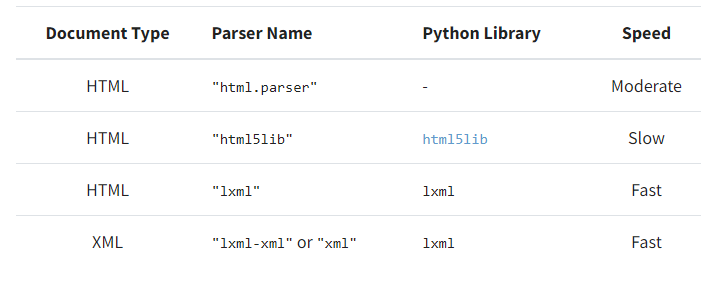

In [ ]:
from bs4 import BeautifulSoup

# Parse XML from a file object
with open("sample_svg.xml") as file:
    soup = BeautifulSoup(file, features="lxml-xml")

# Parse XML from a Python string
soup = BeautifulSoup("""\
<svg viewBox="-105 -100 210 270">
  <!-- More content goes here... -->
</svg>
""", features="lxml-xml")

In [3]:
# Building xml from csv files

csv_file = """name,age,job
Alice,25,Software Engineer
Bob,30,Data Scientist
Carol,28,Product Manager"""

csv_file = csv_file.split('\n')
reader = [data.split(',') for data in csv_file]
reader

[['name', 'age', 'job'],
 ['Alice', '25', 'Software Engineer'],
 ['Bob', '30', 'Data Scientist'],
 ['Carol', '28', 'Product Manager']]

In [4]:
import csv
import xml.etree.ElementTree as ET

# Create the root element
root = ET.Element("root")

# Iterate over the rows in the CSV file
for row in reader:
    # Create a new element for each row
    element = ET.SubElement(root, "row")

    # Add the values from the CSV row to the element
    for value in row:
        ET.SubElement(element, "value").text = value

# Write the XML file
with open("data.xml", "w") as xmlfile:
    xmlfile.write(ET.tostring(root, encoding="unicode"))

### To parse XML using XSLT in Python, you can use the lxml library. Here are the steps:


Import the lxml.etree library.

Parse the XML file using the ET.parse() function.

Parse the XSLT file using the ET.parse() function.

Create a transform object using the ET.XSLT() function.

Apply the transform to the XML document using the transform() function.

Get the result of the transformation as a string using the ET.tostring() function.

In [6]:
import lxml.etree as ET
xml_filename = "xml_data_worker.xml"
xsl_filename = "city_workers.xslt"

In [7]:
dom = ET.parse(xml_filename)
xslt = ET.parse(xsl_filename)

In [9]:
from rich import print

In [ ]:
transform = ET.XSLT(xslt)
newdom = transform(dom)
print(ET.tostring(newdom, pretty_print=True))

In [11]:
with open("city_workers.xml", "w") as xmlfile:
    xmlfile.write(ET.tostring(newdom, encoding="unicode"))

In [12]:
from xml.dom.minidom import parseString

newdom_min = parseString(ET.tostring(newdom, encoding='unicode'))

In [ ]:
print(newdom_min.toprettyxml())  # print with rich provides the look and feel of the xml data

The XML objects can be bound to Python Objects using xpath

Build a custom protocol and use data binding to translate XML into native Python objects.
Define a data model declaratively using Xpath, and extract the information from XML (refer server.py)

Interesting option would be defining custom model classes with descriptors that declare how to look up information using XPath expressions. That’s the part that starts to resemble Django models or Pydantic schema definitions.

In [16]:
import lxml.objectify

class XPath:
    def __init__(self, expression, /, default=None, multiple=False):
        self.expression = expression
        self.default = default
        self.multiple = multiple

    def __set_name__(self, owner, name):
        self.attribute_name = name
        self.annotation = owner.__annotations__.get(name)

    def __get__(self, instance, owner):
        value = self.extract(instance.xml)
        instance.__dict__[self.attribute_name] = value
        return value

    def extract(self, xml):
        elements = xml.xpath(self.expression)
        if elements:
            if self.multiple:
                if self.annotation:
                    return [self.annotation(x) for x in elements]
                else:
                    return elements
            else:
                first = elements[0]
                if self.annotation:
                    return self.annotation(first)
                else:
                    return first
        else:
            return self.default

class Model:
    """Abstract base class for your models."""
    def __init__(self, data):
        if isinstance(data, str):
            self.xml = lxml.objectify.fromstring(data)
        elif isinstance(data, lxml.objectify.ObjectifiedElement):
            self.xml = data
        else:
            raise TypeError("Unsupported data type:", type(data))
        

class Event(Model):
    """Base class for event messages with common elements."""
    type_: str = XPath("./Type")
    timestamp: float = XPath("./Timestamp")

class Modifiers(Model):
    alt: bool = XPath("./Alt")
    ctrl: bool = XPath("./Ctrl")
    shift: bool = XPath("./Shift")
    meta: bool = XPath("./Meta")

class KeyboardEvent(Event):
    key: str = XPath("./Key/Code")
    modifiers: Modifiers = XPath("./Modifiers")

class MouseEvent(Event):
    x: int = XPath("./Cursor/Screen/@x")
    y: int = XPath("./Cursor/Screen/@y")
    modifiers: Modifiers = XPath("./Modifiers")

In [18]:
import xml

In [ ]:
if xml.tag == "KeyboardEvent":
    event = KeyboardEvent(xml)
    if event.type_ == "keyup":
        print("Key:", event.key)
elif xml.tag == "MouseEvent":
    event = MouseEvent(xml)
    print("Mouse:", event.x, event.y)
else:
    print("Unrecognized event type")

#### https://pypi.org/project/PyXB/

PyXB is pure python package, generated python code from the classes that correspond to datastructures defined by XMLSchema

#### http://hg.code.sf.net/p/generateds/code

generateDS is another library that creates Python DS from xml

In [ ]:
##### Dont run this cell, its xml-bomb code that creates recursive references

import xml.etree.ElementTree as ET
ET.fromstring("""\
<?xml version="1.0"?>
<!DOCTYPE lolz [
 <!ENTITY lol "lol">
 <!ELEMENT lolz (#PCDATA)>
 <!ENTITY lol1 "&lol;&lol;&lol;&lol;&lol;&lol;&lol;&lol;&lol;&lol;">
 <!ENTITY lol2 "&lol1;&lol1;&lol1;&lol1;&lol1;&lol1;&lol1;&lol1;&lol1;&lol1;">
 <!ENTITY lol3 "&lol2;&lol2;&lol2;&lol2;&lol2;&lol2;&lol2;&lol2;&lol2;&lol2;">
 <!ENTITY lol4 "&lol3;&lol3;&lol3;&lol3;&lol3;&lol3;&lol3;&lol3;&lol3;&lol3;">
 <!ENTITY lol5 "&lol4;&lol4;&lol4;&lol4;&lol4;&lol4;&lol4;&lol4;&lol4;&lol4;">
 <!ENTITY lol6 "&lol5;&lol5;&lol5;&lol5;&lol5;&lol5;&lol5;&lol5;&lol5;&lol5;">
 <!ENTITY lol7 "&lol6;&lol6;&lol6;&lol6;&lol6;&lol6;&lol6;&lol6;&lol6;&lol6;">
 <!ENTITY lol8 "&lol7;&lol7;&lol7;&lol7;&lol7;&lol7;&lol7;&lol7;&lol7;&lol7;">
 <!ENTITY lol9 "&lol8;&lol8;&lol8;&lol8;&lol8;&lol8;&lol8;&lol8;&lol8;&lol8;">
]>
<lolz>&lol9;</lolz>""")

In [21]:
from xml.sax import make_parser
from xml.sax.handler import feature_external_ges

parser = make_parser()
parser.setFeature(feature_external_ges, True)

In [ ]:
#### This is attack vector..
from xml.dom.minidom import parseString
#  attack known as XXE takes advantage of general external entities
xml = """\
<?xml version="1.0" encoding="UTF-8"?>
<!DOCTYPE root [
    <!ENTITY usernames SYSTEM "/etc/passwd">
]>
<root>&usernames;</root>"""

document = parseString(xml, parser)

print(document.documentElement.toxml())